#Conversational Chatbot


## Syed Mehedi Hasan


## Readme
###How to Run:


#### 1. To start chatting please goto Menu ->Runtime-> Run all or directly press (ctrl + F9) from keyboard.
#### 2. Please click on google link on cell 1.1.2 and provide google log in detail, it will give authentication ID please copy authentication code and paste in input box below the link

#### 3. Then please go to cell 3.5.2. Execute program - chatting mode (please type "xxx" to Exit from current personality mode and enter 0 to exit chatbot)
####All Models, ipython notebook and chatlogs are available in the link below: https://drive.google.com/open?id=1HDThzAsIsDxADWR5XEIV9DxZdDEZUr4n



***Visualising the comparison of different results is a good way to justify your decision.***

# 1 - Data Preprocessing (Personality chat datasets)

## 1.1. Download Dataset (Personality chat datasets)

###1.1.1 Import libraries

In [0]:
#1.1----Load---libraries------
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('stopwords')

from nltk.corpus import stopwords
from gensim.models import Word2Vec

nltk.download('punkt')

import pprint
import re
from lxml import etree
import nltk


from gensim.models import Word2Vec

import torch
import pickle
from gensim import models
import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.6/dist-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


###1.1.2 Download Personality chatbot data set

In [0]:
# Install PyDrive and import libraries 
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


id = '1T6b7WLUeAchBKnaP10gH2aSOEARJLM6Q'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('qna_chitchat_the_professional.tsv') 
downloaded = drive.CreateFile({'id':'1Jl-m5Q_SRDF_VfA8QT1lrE-1k2Vc6pYG'})
downloaded.GetContentFile('qna_chitchat_the_friend.tsv') 
downloaded = drive.CreateFile({'id':'1Dlm69VvrxC4Y8NS2abK3B5jKtos8sy2C'})
downloaded.GetContentFile('qna_chitchat_the_comic.tsv') 

df_prof = pd.read_csv('qna_chitchat_the_professional.tsv', sep="\t")
df_fr = pd.read_csv('qna_chitchat_the_friend.tsv', sep="\t")
df_com = pd.read_csv('qna_chitchat_the_comic.tsv', sep="\t")


    100% |████████████████████████████████| 993kB 20.9MB/s 


## 1.2. Preprocess data (Personality chat datasets)

####We used tokenization, remove unnecessary numbers and punctuations.Then we are converting all tokens to lowercase so that we can get same vector for each token word whether it is in uppercase, lower case or mixed case.We did not remove stop words as some questions are formed with only NLTK.corpus stop words. We keep three personality type data in three data frame and make the dictionary for three set answers. We added four special char (_E_, _B_, _P_,_U_) to each dictionary as it is very important.We used that to form input_batch, output_batch, and target.

In [0]:
# Read Personality chat datasets
df_prof.head(4)


,Question,Answer,Source,Metadata
0,What's your age?,Age doesn't really apply to me.,qna_chitchat_the_professional,editorial:chitchat
1,Are you young?,Age doesn't really apply to me.,qna_chitchat_the_professional,editorial:chitchat
2,When were you born?,Age doesn't really apply to me.,qna_chitchat_the_professional,editorial:chitchat
3,What age are you?,Age doesn't really apply to me.,qna_chitchat_the_professional,editorial:chitchat


In [0]:
#concat all three chat data frame together. we will add all questions from here to our movie line data
# to make richer Word2Vec Model
df_all=pd.concat([df_prof,df_fr,df_com])



### 1.2.1 Tokenisation, stopwords removal, stemming etc

In [0]:
## Functions to pre-process data for Seq2Seq Model---

#Maximum number of words in a question for a given Personality
global max_input_words_amount
#Maximum number of sentences will come as output
global max_output_words_amount
#Maximum number of unique answers we kept in dictionary
global max_dic_len

#Take the maximum number of unique answers in any chat data set
max_unique_answers = max (len(list(set(df_prof['Answer']))), len(list(set(df_fr['Answer']))), len(list(set(df_com['Answer']))))

#we added four specail chars to our unique answer
max_dic_len=max_unique_answers + 4

# Generate Sequence-Data from Question and answer data
def get_seq_data(df):
        
        seq_data = []
        whole_words = []
                        
        max_input_words_amount=0
        max_output_words_amount=1
               
        question={}
        answer={}

        #Iterate over all rows of chat data frame
        for index, row in df.iterrows():

            ###
            question[row[0]] = index
            answer[row[1]] = index

            tmp_qa=[]
            tmp_qa.append(row[0])
            tmp_qa.append(row[1])
            seq_data.append(tmp_qa)
           
            
            # tokenise question
            #tokens_q=word_tokenize(row[0])
            tokenized_q =word_tokenize(row[0].lower())

            # we do not need to tokenise answer (because we implement N to One model)
            # make a list with only one element (whole sentence)
            #tokenized_a += row[1]
            tokenized_a=row[1]

            
            # answer list (one element) as we keep only answer to dict
            whole_words.append(tokenized_a)

            # we need to decide the maximum size of input word tokens
            max_input_words_amount = max(len(tokenized_q), max_input_words_amount)


        # we now have a vacabulary list
        unique_words = list(set(whole_words))

        # adding special tokens in the vocabulary list    
        # _B_: Beginning of Sequence
        # _E_: Ending of Sequence
        # _P_: Padding of Sequence - for different size input
        # _U_: Unknown element of Sequence - for different size input

        unique_words.append('_B_')
        unique_words.append('_E_')
        unique_words.append('_P_')
        unique_words.append('_U_')
        
        #make all persnality answer set same length by adding _U_ + str(i+1), i=1 to length different
        if len(unique_words)<max_dic_len:
            diff=max_dic_len-len(unique_words)
            for i in range(diff):
                unique_words.append('_U_' + str(i+1))
        
        
        unique_words.sort()
        num_dic = {n: i for i, n in enumerate(unique_words)}
        
       
          
        dic_len = len(num_dic)
        
        return seq_data, num_dic, unique_words,dic_len
      
 # get token index vector of questions and add paddings if the word is shorter than 
 #the maximum number of words
def get_vectors_q(sentence):
    
    # tokenise the sentence
    
    tokenized_sentence = word_tokenize(sentence.lower())
    
    #calculate lenth different between number of words in  this question and max_input_words_amount
    diff = max_input_words_amount - len(tokenized_sentence)
    
    # add paddings if the word is shorter than the maximum number of words    
    for x in range(diff):
        
        tokenized_sentence.append("_P_")
  
   
    data = [num_dic[n] for n in tokenized_sentence]
           
    
        
    return data

# get token index vector of answer
def get_vectors_a(sentence, num_dic):    
    tokenized_sentence = [sentence]
    data = tokens_to_ids(tokenized_sentence, num_dic)
    
    return data
    

# convert tokens to index
def tokens_to_ids(tokenized_sentence, num_dic):
    ids = []

    for token in tokenized_sentence:
        
        if token in num_dic:
            ids.append(num_dic[token])
        else:
            ids.append(num_dic['_U_'])
          

    return ids
  
#Get Word2Vec for each word of question(sentence) and join those to an array of vector
def get_w2vec(model,sentence):
    
    # tokenise the sentence and take lower case
    
    tokenized_sentence = word_tokenize(sentence.lower())
      
    
    diff = max_input_words_amount - len(tokenized_sentence)
    
    # add paddings if the word is shorter than the maximum number of words    
    for x in range(diff):
        
        tokenized_sentence.append("_P_")
        
                
    data=[] 
    
    #data = [get_vector(model, n) for n in tokenized_sentence]
    #data = np.eye(dic_len)[data]
    
    #get vector for each word of a question from word2vec model
    for w in tokenized_sentence:
      data.append(get_vector(model, w))
    
        
    return data
  
#get a vector corresponding to a word from given model
def get_vector(model, word):
  
  
  if word in model.wv:
    vector = model.wv[word]  
  else:
    
    vector = model.wv['_U_'] 
  return vector
  
  
  # generate a batch data for training/testing
def make_batch_new(seq_data, num_dic, model):
    input_batch = []
    output_batch = []
    target_batch = []
    #target=[]
    
    dic_len=len(num_dic)
    
    for seq in seq_data:        
        # Input for encoder cell, convert question to vector
        input_data = get_w2vec(model,seq[0]) #get_vectors_q(seq[0])
             
        
        # Input for decoder cell, Add '_B_' at the beginning of the sequence data
 
        tmp_seq= seq[1]
        output_data = [num_dic['_B_']]
         
        output_data += get_vectors_a(seq[1], num_dic)
        
        # Output of decoder cell (Actual result), Add '_E_' at the end of the sequence data
       
        target = [num_dic[seq[1]]]
        tmp_target = num_dic['_E_']
        target.append(tmp_target)                        
        
        
       
        #append word2vec vector for each word of question to input_batch
        input_batch.append(input_data)
        
        # Convert number got for each answer from our dictionary to one-hot encode data
        output_batch.append(np.eye(dic_len)[output_data])
        
        target_batch.append(target)
        #s=seq
               

    return input_batch, output_batch, target_batch

#Set  global variables max_input_words_amount and max_output_words_amount
def set_max_input_words_amount(seq_data):
    
    global max_input_words_amount
    global max_output_words_amount
    
    max_input_words_amount=0
    max_output_words_amount=1
    for row in seq_data:
  
        tokenized_q =word_tokenize(row[0].lower())
            
        
        # we need to decide the maximum size of input word tokens
        max_input_words_amount = max(len(tokenized_q), max_input_words_amount)

### 1.2.2 Pickle Dictionary

In [0]:
# Comment this code as we used the function below to make those data: (seq_data, num_dic, unique_words)
#and upload those data as pickled file in google drive and used those file to get data for model

'''
# make and upload these (seq_data, num_dic, unique_words) to google drive using google drive mount and torch library
def upload_pickle_data(df, personality_extention):
  
    seq_data, num_dic, unique_words,dic_len =get_seq_data(df)

    drive.mount('/content/gdrive')

    #Save model to google drive. Comment this part as already uploaded
    dic_save_name = 'num_dic_' + str(personality_extention)

    path = F"/content/gdrive/My Drive/Comp5046_Assignment1/Model/Pickle_data/{dic_save_name}" 
    torch.save(num_dic, path)

    seq_data_save_name='seq_data_' + str(personality_extention)
    path = F"/content/gdrive/My Drive/Comp5046_Assignment1/Model/Pickle_data/{seq_data_save_name}" 
    torch.save(seq_data, path)

    unique_words_save_name='unique_words_' + str(personality_extention)
    unique_words_path = F"/content/gdrive/My Drive/Comp5046_Assignment1/Model/Pickle_data/{unique_words_save_name}" 
    torch.save(unique_words, unique_words_path)
    
    '''


'\n# make and upload these (seq_data, num_dic, unique_words) to google drive using google drive mount and torch library\ndef upload_pickle_data(df, personality_extention):\n  \n    seq_data, num_dic, unique_words,dic_len =get_seq_data(df)\n\n    drive.mount(\'/content/gdrive\')\n\n    #Save model to google drive. Comment this part as already uploaded\n    dic_save_name = \'num_dic_\' + str(personality_extention)\n\n    path = F"/content/gdrive/My Drive/Comp5046_Assignment1/Model/Pickle_data/{dic_save_name}" \n    torch.save(num_dic, path)\n\n    seq_data_save_name=\'seq_data_\' + str(personality_extention)\n    path = F"/content/gdrive/My Drive/Comp5046_Assignment1/Model/Pickle_data/{seq_data_save_name}" \n    torch.save(seq_data, path)\n\n    unique_words_save_name=\'unique_words_\' + str(personality_extention)\n    unique_words_path = F"/content/gdrive/My Drive/Comp5046_Assignment1/Model/Pickle_data/{unique_words_save_name}" \n    torch.save(unique_words, unique_words_path)\n    \n  

#### Upload Pickled data for num_dic, Seq_data and unique_words to google drive

In [0]:
#comment this code as we already uploaded those data to google drive and will train model 
#after downloading that

#upload_pickle_data(df_prof, 'prof')
#upload_pickle_data(df_com, 'com')
#upload_pickle_data(df_fr, 'fr')

### Load Dictionary and Seq_Data from google drive

In [0]:
#1.2.2.1 --- Custom functions-- Load dictionary and list data for Seq-Data from Google drive--

#load pickled data from google drive (num_dict, seq-data, ma) using google py drive and torch library

def load_pickle_data(personality_type):
      
      #if profesional personality then download corresponding pickle data from google drive
      if personality_type==1:
        extension='prof'
        unique_words_id='1-DXWJnYIw3IvdoM753kaFuV5B1_k29-c'
        seq_data_id='1-DVdb6CAbvkg0LbCbJVempQOZqSeHo3Q'
        num_dic_id='1-B5GfNBOdkLOru-AOziWgkK47diurGY4'
        
      #if comic personality then download corresponding pickle data from google drive
      elif personality_type==2:
        extension='com'
        unique_words_id='1-M0qD6e_FmmnM1w7SAgkN07Zz5_q60Wo'
        seq_data_id='1-KgsKQz3S9va2OY3QYi-tu0EygIAh8zU'
        num_dic_id='1-KDAiqFcn_ZHkGfOJKq8eyijoay6P7zu'
      
      #if friend personality then download corresponding pickle data from google drive
      elif personality_type==3:
        extension='fr'
        unique_words_id='1-Q6I46Glmmdsg6CgrLR8YjgXRsNvUkrp'
        seq_data_id='1-O8QsFwaEgbVba25DhbaDo5ch4LG8wvJ'
        num_dic_id='1-R_A0WLphGMmTpgXRKzlp3E_OBG2eiZq'

             
      file_unique_words = drive.CreateFile({'id':unique_words_id})
  
      file_unique_words.GetContentFile('unique_words_prof')
      unique_words=torch.load('unique_words_prof')
      
      
      
      file_seq_data = drive.CreateFile({'id':seq_data_id})
  
      file_seq_data.GetContentFile('seq_data_prof')
      seq_data=torch.load('seq_data_prof')
      
      
            
      file_num_dic = drive.CreateFile({'id':num_dic_id})
  
      file_num_dic.GetContentFile('num_dic_prof')
      num_dic=torch.load('num_dic_prof')
      
      #Set maximum number of words in any single question of this personality chat.
      set_max_input_words_amount(seq_data)
      return seq_data, num_dic, unique_words, len(num_dic)




In [0]:
#Load seq_data, num_dic for professional type chat as default type from pickled file in google drive
seq_data, num_dic, unique_words,dic_len =load_pickle_data(1)


# 2 - Model Implementation

## 2.1. Word Embeddings

#####We used Word2Vec with CBOW
#### We used size of vector size as length of dict_len i.e total number of unique answers. It is very important otherwise our shapes of our input-batch and output-batch  will be different, that will give trouble to Neural Network.We here keep dic_len same for all personality to use NN in same format.



In [0]:
# Please comment your code
#Generate a cleaned data for Word2Vec 

def get_cleaned_data(df):
  
   
    words=[]
    clean_words=[]
    
    for index, row in df.iterrows():
      
            sents_lst=[]
            sent1=row[0]
           
            sents_lst.append(sent1)
                        
            for sent in sents_lst:
                  #apply regular expresion to whole text to remove number and punctualtion
                  sents1 = re.sub(r"[^a-z0-9]+", " ", sent.lower())
                  #tokenize as
                  sent_text=sent_tokenize(sents1)

                  normalized_text = []

                  for string in sent_text:
                      #apply regular expresiont to each sentence again
                      tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
                      normalized_text.append(tokens)

                      # Tokenising each sentence to process individual word
                      sentences=[]
                      sentences=[word_tokenize(sentence) for sentence in normalized_text]
                      
                      #remove stop words using NLTK stop word dictionary for English Language
                      sentences=remove_stop_words(sentences)
                      clean_words.append(sentences)
           
      
    #Flattend the list, reduce to one dimension lower
    flattened = [val for sublist in clean_words for val in sublist]
    
    clean_words=flattened
    
    sents=[]
    sents.append('_B_')
    sents.append('_E_')
    sents.append('_P_')
    sents.append('_U_')
    clean_words.append(sents)
    return clean_words

# Function for Removing Stop Words using NLTK stop word dictionary for English language

def remove_stop_words(all_words):
  
    all_words_new=[]
    for i in range(len(all_words)): 
        
        sent_words=all_words[i]
        sent_words_new=[]
        for word in sent_words:
            if word not in stopwords.words('english'):
                sent_words_new.append(word)
        all_words_new.append(sent_words_new)
        
    return all_words_new
  

#Generate a a single of Word2Vec Model
def generate_word2vec_model(df):
 
    #Get cleaned and processed data
    lst_words=  get_cleaned_data(df)
  
    tmp_model=Word2Vec(sentences=lst_words, size=max_dic_len, window=5, min_count=1, workers=4, sg=0)
    tmp_model.train(lst_words, total_examples=len(lst_words), epochs=10)
    
    
    return tmp_model


#get a vector corresponding to a word from given model
def get_vector(model, word):
  
  
  if word in model.wv:
    vector = model.wv[word]  
  else:
    
    vector = model.wv['_U_']
    
  return vector


### 2.1.1. Download Dataset for Word Embeddings



#### To build a rich Word2Vec model we chose to use Corneille Movie data. The idea behind that is if we train our Word2Vec on large amounts of natural language data, we should be able to get  vector representations for each word that capture the semantic similarity between words. So, we can a get much reliable vector corresponding to each word of user question. We also added all questions from Microsoft chat data to get richer Word2Vec model. So, our word2vec mdel is richer and specially this microsoft chat data, they will be able to give more acurate vector.

In [0]:
#Read movie_lines,txt file and clean and process data, store in pandas data frame


file_movie = drive.CreateFile({'id':'1ZvYX0VnPqd9nU2oJ9x6BwsqvGnXpQjgG'})
file_movie.GetContentFile('movie_lines.txt') 

with open(file_movie['title'],encoding='utf-8', errors='ignore') as f: 
    lines = f.readlines() 

sents=[]
for line in lines:
        words = line.split('+++$+++')
        str1=words[4]
        i=str1.index('\n')
        str2=str1[:i]
        sents.append(str2)

# adding special tokens in the vocabulary list    
# _B_: Beginning of Sequence
# _E_: Ending of Sequence
# _P_: Padding of Sequence - for different size input
# _U_: Unknown element of Sequence - for different size input

sents.append('_B_')
sents.append('_E_')
sents.append('_P_')
sents.append('_U_')

df_movie=pd.DataFrame(sents, columns=['Question'])
df_movie.head(3)


,Question
0,They do not!
1,They do to!
2,I hope so.


### 2.1.2. Data Preprocessing for Word Embeddings

####We used tokenization, remove unnecessary numbers and punctuations.Then we are converting all tokens to lowercase that we can get same vector for each token word whether it is uppercase, lower case or mixed case.Finally we removed stops using NLTK stopwords dictionary. 
We added the following chars to our word2vec model
._B_: Beginning of Sequence
 _E_: Ending of Sequence
 _P_: Padding of Sequence - for different size input
 _U_: Unknown element of Sequence - 
 The reason is we added those with our input-batch and output batch  when we send user question to model in chat mode



In [0]:
# Add all Questions of all personality from Microsoft chat data to movie data frame
#We comment this as we already build Word Embedding Model and uploaded to google drive and
#Use that model after downloading that

'''
df_tmp=df_movie

for i, row in df_all.iterrows():
    df_tmp = df_tmp.append([{'Question':row[0]}], ignore_index=True)

df_movie=df_tmp

'''

"\ndf_tmp=df_movie\n\nfor i, row in df_all.iterrows():\n    df_tmp = df_tmp.append([{'Question':row[0]}], ignore_index=True)\n\ndf_movie=df_tmp\n\n"

### 2.1.3. Build and Train Word Embeddings Model

#### We have used here Gensim library function to build and train model. Only few parameters we set here that we specially need for our model here, rest we used gensim's default hyperparameter. We put min_count=1 otherwise we will not be able to get special characrers we added with word list.We used window size= 5 as a standard window size.we put sg=0 as we used cbow. We used size of vector size as length of dict_len i.e total number of unique answers(102 here). It is very important otherwise our shapes of our input-batch and output-batch  will be different, that will give trouble to Neural Network.We here keep dic_len same for all personality to use NN in same format by adding special chars if it need

In [0]:
# Generate WordeVec model from movie data and train the model using Gensim. Long file will take 10-15 minutes..
#Commented as downloading word2vec model from my Google drive

#model_movie=generate_word2vec_model(df_movie)

### Training loss Word2Vec

In [0]:
## We comment this code as it takes long time and we only use that   
## to show how loss decrease  with decrease of learning rate(i.e to determine best Learning Rate).
## although we checked that default hyperparameter used in gensim is good enough, so we kept that.
'''
df=df_movie
lst_words=  get_cleaned_data(df)

word2vec_params = {
   'sg': 0,  # 0 ： CBOW； 1 : skip-gram
   "size": 102,
   "alpha": 0.5,
   "min_alpha": 0.001,
   'window':10,
   'min_count': 1,
   'seed': 1,
   "workers": 4,
   "negative": 0,
   "hs": 1,  # 0: negative sampling, 1:hierarchical  softmax
   'compute_loss': True,
   'iter': 10,
   'cbow_mean':1,
}

model = Word2Vec(**word2vec_params)
model.build_vocab(sentences=lst_words)
losses = []
learning_rate = 0.5
step_size = (0.5 - 0.001) / 10

for i in range(10):
    trained_word_count, raw_word_count = model.train(sentences=lst_words, compute_loss=True,
                                                     start_alpha=learning_rate,
                                                     end_alpha=learning_rate,
                                                     total_examples=model.corpus_count,
                                                     epochs=1)
    loss = model.get_latest_training_loss()
    losses.append(loss)
    print(i, loss, learning_rate)
    learning_rate -= step_size
    
'''

'\ndf=df_movie\nlst_words=  get_cleaned_data(df)\n\nword2vec_params = {\n   \'sg\': 0,  # 0 ： CBOW； 1 : skip-gram\n   "size": 102,\n   "alpha": 0.5,\n   "min_alpha": 0.001,\n   \'window\':10,\n   \'min_count\': 1,\n   \'seed\': 1,\n   "workers": 4,\n   "negative": 0,\n   "hs": 1,  # 0: negative sampling, 1:hierarchical  softmax\n   \'compute_loss\': True,\n   \'iter\': 10,\n   \'cbow_mean\':1,\n}\n\nmodel = Word2Vec(**word2vec_params)\nmodel.build_vocab(sentences=lst_words)\nlosses = []\nlearning_rate = 0.5\nstep_size = (0.5 - 0.001) / 10\n\nfor i in range(10):\n    trained_word_count, raw_word_count = model.train(sentences=lst_words, compute_loss=True,\n                                                     start_alpha=learning_rate,\n                                                     end_alpha=learning_rate,\n                                                     total_examples=model.corpus_count,\n                                                     epochs=1)\n    loss = model.get_lat

#### Show justfication of taking very small Learning rate during training Word2Vec Model

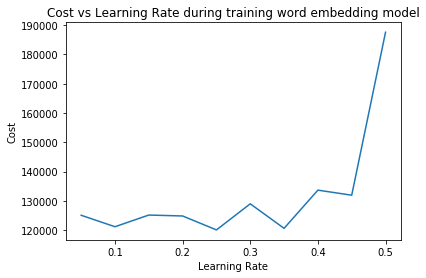

In [0]:
import matplotlib.pyplot as plt
W2V_LR=np.array([[0.5,0.45,0.40,0.35,0.30,0.25,0.20,0.15,0.10,0.05],[187598.54,131910.65,133637.01,120588.58,128964.39, 120045.54,124809.89,125126.57,121136.02,125049.44]])

plt.plot(W2V_LR[0],W2V_LR[1])
plt.xlabel('Learning Rate')
plt.ylabel('Cost')
plt.title('Cost vs Learning Rate during training word embedding model')
plt.show()

### 2.1.4. Train Word Embeddings Model

In [0]:
# Generate WordeVec model from movie data and train the model using Gensim. Long file will take 10-15 minutes.
#Commented as downloading word2vec model from my Google drive. please uncomment it if you want to run

#model_movie=generate_word2vec_model(df_movie)




### 2.1.5. Save Word Embeddings Model

In [0]:
# Save the Word2Vec Model we comment it as we already uploaded using google drive mount.

#from google.colab import drive
#drive.mount('/content/gdrive')


#Save model to google drive. Comment this part as already uploaded
#model_save_name = 'model_Embedding.pt'
#path = F"/content/gdrive/My Drive/Comp5046_Assignment1/Model/{model_save_name}" 
#torch.save(model_movie, path)

### 2.1.6. Load Word Embeddings Model

In [0]:
#Function-- Load Word2Vec_model-- from google drive using Pydrive

def load_Word2Vec_model():
    
    #Create file using google file Id of our Word Embedding Model (model_Embedding.pt)
    downloaded = drive.CreateFile({'id':'1-6gR2fmUJqFXtASJULlhPz2rzMRnFCce'})
  
    downloaded.GetContentFile('model_Embedding.pt')
    model_movie_downloaded=torch.load('model_Embedding.pt')
       

    return model_movie_downloaded





## 2.2. Seq2Seq model

### 2.2.1. Apply/Import Word Embedding Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

In [0]:
# Load word2Vec model from google drive
model_movie=load_Word2Vec_model()


### 2.2.2. Build Seq2Seq Model

##### We used several hyperparameter 1. learning_rate we keep it small to converge it to global minimum. 2. n_hidden: is the number of hidden layer in NN. we keep it high enough to get better accuracy.3. n_class and n_input : We had to keep it total number of unique answers in our specific data (max_dic_len)

In [0]:
#Load seq_data, num_dic.. from pickled file in google drive default we chose 1=professional personality
seq_data, num_dic, unique_words,dic_len =load_pickle_data(1)



In [0]:
  #2.2.2 Initialise Seq2Seq Model using Tensorflow------
  
  import tensorflow as tf
  
  ### Setting Hyperparameters

  ### Neural Network Model
  tf.reset_default_graph()

  learning_rate = 0.002
  n_hidden = 128

  n_class = dic_len
  n_input = dic_len
  

  # encoder/decoder shape = [batch size, time steps, input size]
  enc_input = tf.placeholder(tf.float32, [None, None, n_input])
  dec_input = tf.placeholder(tf.float32, [None, None, n_input])

  # target shape = [batch size, time steps]
  targets = tf.placeholder(tf.int64, [None, None])


  # Encoder Cell
  with tf.variable_scope('encode'):
      enc_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
      enc_cell = tf.nn.rnn_cell.DropoutWrapper(enc_cell, output_keep_prob=0.5)

      outputs, enc_states = tf.nn.dynamic_rnn(enc_cell, enc_input,
                                              dtype=tf.float32)
  # Decoder Cell
  with tf.variable_scope('decode'):
      dec_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
      dec_cell = tf.nn.rnn_cell.DropoutWrapper(dec_cell, output_keep_prob=0.5)

      # [IMPORTANT] Setting enc_states as inital_state of decoder cell
      outputs, dec_states = tf.nn.dynamic_rnn(dec_cell, dec_input,
                                              initial_state=enc_states,
                                           dtype=tf.float32)



      model = tf.layers.dense(outputs, n_class, activation=None)

      cost = tf.reduce_mean(
                  tf.nn.sparse_softmax_cross_entropy_with_logits(
                      logits=model, labels=targets))

      optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


      # Generate a batch data
      input_batch, output_batch, target_batch = make_batch_new(seq_data, num_dic, model_movie)

          #-------------------------------------------------------

          

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.


### 2.2.3. Train and Save Seq2Seq Model
##### We commented code here as we already train and save Seq2Seq model for all personality chat in google drive and using model downloading from there.

In [0]:
'''
# We do not need to run this block of code as we saved and uploaded the session to google drive will 
#used that saved session for our chatbot

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

saver = tf.train.Saver()

with tf.Session() as sess:

      sess.run(init)

     
      # Please comment your code
      total_epoch = 5000

      for epoch in range(total_epoch):
          _, loss = sess.run([optimizer, cost],
                             feed_dict={enc_input: input_batch,
                                        dec_input: output_batch,
                                        targets: target_batch})
          if epoch % 100 == 0:
              print('Epoch:', '%04d' % (epoch + 1),
                    'cost =', '{:.6f}'.format(loss))

      print('Epoch:', '%04d' % (epoch + 1),
            'cost =', '{:.6f}'.format(loss))
      print('Training completed')

            # Save the model - This will generate three files: 
            # 1) model_final.cpkt.index, 2) model_final.cpkt.meta, 3) model_final.cpkt.data-#-of-# (model_final.cpkt.data-00000-of-00001)
            #saver.save(sess, 'model_Seq2Seq_com.cpkt')
      model_save_name = 'model_Seq2Seq_fr.cpkt'
      path = F"/content/gdrive/My Drive/Comp5046_Assignment1/Model/Fr/{model_save_name}" 
      
      
      saver.save(sess, path)
      
'''


'\n# We do not need to run this block of code as we saved and uploaded the session to google drive will \n#used that saved session for our chatbot\n\n# Initialize the variables (i.e. assign their default value)\ninit = tf.global_variables_initializer()\n\nsaver = tf.train.Saver()\n\nwith tf.Session() as sess:\n\n      sess.run(init)\n\n     \n      # Please comment your code\n      total_epoch = 5000\n\n      for epoch in range(total_epoch):\n          _, loss = sess.run([optimizer, cost],\n                             feed_dict={enc_input: input_batch,\n                                        dec_input: output_batch,\n                                        targets: target_batch})\n          if epoch % 100 == 0:\n              print(\'Epoch:\', \'%04d\' % (epoch + 1),\n                    \'cost =\', \'{:.6f}\'.format(loss))\n\n      print(\'Epoch:\', \'%04d\' % (epoch + 1),\n            \'cost =\', \'{:.6f}\'.format(loss))\n      print(\'Training completed\')\n\n            # Save th

#### Show justfication of using number of epochs during training neural network for sequence to sequence model

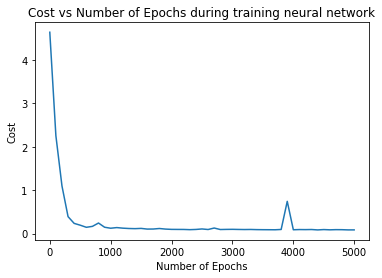

In [0]:
#During training we saved this data to data folder in google drive as txt file and 
#showing graph from that file data
import pandas as pd
import matplotlib.pyplot as plt

Seq_Epochs = drive.CreateFile({'id':'1L3TQba_EcFrluJLqWvFJErKg8QuC6VLf'})
Seq_Epochs.GetContentFile('Seq_Epochs.txt') 


df=pd.read_csv('Seq_Epochs.txt', sep=' ', header=None)
df.head()

plt.plot(df[1],df[4])
plt.xlabel('Number of Epochs')
plt.ylabel('Cost')
plt.title('Cost vs Number of Epochs during training neural network')
plt.show()

### 2.2.4. Save Seq2Seq Model

In [0]:
# We have saved and upload Seq2Seq model as Tensorflow  session in google drive in section 2.2.3

### 2.2.5. Load Seq2Seq Model

In [0]:
# Load Seq2seq model from google drive using pyDrive using ListFile function
# We downloaded all files related to a Seq2Seq model to colab temporary drive and use from there.
#Here we used Google File Id of a folder where our Seq2Seq model files saved as we saved each personality model in different folder

def load_Seq2Seq_model(personality_type):
      
      #Seq2seq model of professional chat
      if personality_type==1:
        file_list = drive.ListFile({'q': "'1QiJWwtqmvepmxJBwtlJXYGa4HtbwuT2A' in parents and trashed=false"}).GetList()
        session_path='model_Seq2Seq_prof.cpkt'
      
      #Seq2seq model of comic chat
      elif personality_type==2:
        file_list = drive.ListFile({'q': "'13ussiFGW1uqkbF22jwOHvwfGuqicH1f1' in parents and trashed=false"}).GetList()
        session_path='model_Seq2Seq_com.cpkt'
      
      #Seq2seq model of Friend chat
      elif personality_type==3:
          session_path='model_Seq2Seq_fr.cpkt'
          file_list = drive.ListFile({'q': "'1euc1V3nSvWc_Vr6zPe-sLSy9cjK75MGP' in parents and trashed=false"}).GetList()

      saver = tf.train.Saver()

      init = tf.global_variables_initializer()
      sess=tf.Session()

      sess.run(init)

      #Create file on colab Files folder all file of a specific folder
      for file1 in file_list:
              
        seq_model_id = file1['id']
        downloaded_seq_model = drive.CreateFile({'id':seq_model_id})
        downloaded_seq_model.GetContentFile(file1['title'])
      
      #restore checkpoint
      saver.restore(sess, session_path)
      print("Model restored.")
        
      return sess

In [0]:
import tensorflow as tf

sess_load=load_Seq2Seq_model(1)


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model_Seq2Seq_prof.cpkt
Model restored.


# 3 - Evaluation (Running chatbot)

## 3.1. Start chatting

In [0]:
# 3.1----Functions for answer by chatbot and save chat log------


# Answer the question using the trained model
def answer(sess, sentence, chat_type=1):
    
    #load seq_data, num_dic and unique answers from google drive file
    if chat_type==1:
        seq_data, num_dic, unique_words,dic_len =load_pickle_data(chat_type)
    elif chat_type==2:
        seq_data, num_dic, unique_words,dic_len =load_pickle_data(chat_type)
    elif chat_type==3:
        seq_data, num_dic, unique_words,dic_len =load_pickle_data(chat_type)
    else:
        seq_data, num_dic, unique_words,dic_len =load_pickle_data(chat_type) 
    
    #Make seq_data with question and initailly undefined answer.    
    seq_data = [sentence, '_U_' * max_output_words_amount]
    
    #make batch using seq_data that will feed to NN
    input_batch, output_batch, target_batch = make_batch_new([seq_data],num_dic, model_movie)
    
    prediction = tf.argmax(model, 2)

    result = sess.run(prediction,
                      feed_dict={enc_input: input_batch,
                                 dec_input: output_batch,
                                 targets: target_batch})

    # convert index number to actual token 
    decoded = [unique_words[i] for i in result[0]]
        
    # Remove anything after '_E_'        
    if "_E_" in decoded:
        end = decoded.index('_E_')
        translated = ' '.join(decoded[:end])
    else :
        translated = ' '.join(decoded[:])
    
    return translated
  
#write chat_log to google drive in under chat_log folder using pydrive
def write_chat_log(g_drive,file_name, lst_chat):
     
    #create file using pydrive and use file_name as title
    file_chat = g_drive.CreateFile({'title': file_name})
    
    #Create file under a folder provided by the google Id
    file_folder = drive.CreateFile({"parents": [{"kind": "drive#fileLink", "id": '1eV0sIZQpEN3LYUAWiN0gXG1J1iid6_R8'}]})
    
    #open file_chat in write mode and write in it using content of lst_chat
    with open(file_chat['title'], 'w') as myfile:
     
      for l in lst_chat:
          user=np.asarray(l)
          for i in range(len(user[1])):
            
            myfile.write("%s\r\n" % user[0][i])
            myfile.write("%s\r\n" % user[1][i])
        
      myfile.close()
      
      file_folder.SetContentFile(myfile.name)
      file_folder.Upload()
      
def read_chat_log(file_name):

  with open(file_name,encoding='utf-8', errors='ignore') as f: 
      lines = f.readlines() 

  sents=[]
  for line in lines:
    print(line)
    
#Change chat_type(personality) according to user choice    
def change_chat_type(personality_type):
  
      print('Please type "xxx" to exit')
 
      sess_load=load_Seq2Seq_model(personality_type) #


      #Start Chatbot conversation

      global lst_conv
      lst_conv=[]
      #three lists to keep user ques and chatbot answer
      lst_qa=[] 
      lst_q=[]
      lst_a=[]

      ques=input('User: ')
      #Add user question to lst_q
      lst_q.append('User: ' + ques)
      ans=print('Chatbot: ' + answer(sess_load, ques,personality_type))
      #Add chatbot anser to lst_a
      lst_a.append('Chatbot: ' + answer(sess_load, ques,personality_type))
      
      #chat continue with chatbot until user type "xxx"
      while ques.lower()!='xxx':
        
        #ask user input as question
        ques=input('User: ')

        lst_q.append('User: ' + ques)
        if(ques.lower()!='xxx'):
          #get answer from chatbot if ques is not "xxx"
          ans=print('Chatbot: ' + answer(sess_load, ques,personality_type))

          lst_a.append('Chatbot: ' + answer(sess_load, ques,personality_type))
        else:
          #exit from current chatmode if user type "xxx"
          ans=print('Chatbot: ' + 'Thank you. Bye')
          break;
        ques=input('User: ')
        if(ques.lower()=='xxx'):
          ans=print('Chatbot: ' + 'Thank you. Bye')
          break;
        else:
          ans=print('Chatbot: ' + answer(sess_load, ques,personality_type))
          lst_q.append('User: ' + ques)
          lst_a.append('Chatbot: ' + answer(sess_load, ques,personality_type))

      lst_qa.append(lst_q)
      lst_qa.append(lst_a)
      #add list of question and answer to single list as a list of list
      lst_conv.append(lst_qa)

      #make chatlog file extension according to personality type
      if personality_type==1:
        file_ext='prof'
      elif personality_type==2:
        file_ext='com'
      elif personality_type==3:
        file_ext='fr'

      #write to text file
      #Take current time stamp and with file_name
      time_stamp = datetime.datetime.now().timestamp()
      str_time_stamp=str(int(time_stamp))
    
      #make unique file_name using timestapm()     
      file_name='conversation_' + str(file_ext) + "_" + str_time_stamp + '.txt'
      #write chat_log to file in google drive  using data in lst_conv 
      write_chat_log(drive, file_name, lst_conv)
            
      return ques


## 3.2. Change Personality

*Explain how to change personality (What is the command for changing personality?). *

In [0]:
# Change Personality, we comment this code as we call that in chat mode (3,5.2)

#ret=change_chat_type(personality_type)



## 3.3. Save chat log

In [0]:
# write chat log to text file in google drive. we comment here as we called this funtion
# in side the function change_chat_type()

#write_chat_log(g_drive, file_name, lst_conv)


## 3.4. End chatting

In [0]:
# We used End chatting option and change personality option using the function below and last block of code

#ret=change_chat_type(personality_type)


## 3.5. Execute program

***Please make sure your program  is running properly.***

***Functions for downloading (from Google Drive) and loading models (both word embeddings and Seq2Seq) need to be called!*** 


### 3.5.1. Execute program - training mode

*Please include lines to train the bot.*

In [0]:
#We commented this code as we already train model and uploaded to google drive
'''
#1. Load sequence  data from pickled file in google drive
seq_data, num_dic, unique_words,dic_len =load_pickle_data(1)
#load Word2Vec model from google drive
model_movie=load_Word2Vec_model()
#2.2.2
#2.2.3

'''


'\n#1. Load sequence  data from pickled file in google drive\nseq_data, num_dic, unique_words,dic_len =load_pickle_data(1)\n#load Word2Vec model from google drive\nmodel_movie=load_Word2Vec_model()\n#2.2.2\n#2.2.3\n\n'

### 3.5.2. Execute program - chatting mode

*Please include lines to start chatting with the bot.*

In [0]:

#1. Load sequence data and dictionary of answers  data from pickled file in google drive
seq_data, num_dic, unique_words,dic_len =load_pickle_data(1)
#load Word2Vec model from google drive
model_movie=load_Word2Vec_model()


In [0]:
  
  import tensorflow as tf
  ### Setting Hyperparameters

  ### Neural Network Model
  tf.reset_default_graph()

  learning_rate = 0.002
  n_hidden = 128

  n_class = dic_len
  n_input = dic_len

  ### Neural Network Model
  
  # encoder/decoder shape = [batch size, time steps, input size]
  enc_input = tf.placeholder(tf.float32, [None, None, n_input])
  dec_input = tf.placeholder(tf.float32, [None, None, n_input])

  # target shape = [batch size, time steps]
  targets = tf.placeholder(tf.int64, [None, None])


  # Encoder Cell
  with tf.variable_scope('encode'):
      enc_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
      enc_cell = tf.nn.rnn_cell.DropoutWrapper(enc_cell, output_keep_prob=0.5)

      outputs, enc_states = tf.nn.dynamic_rnn(enc_cell, enc_input,
                                              dtype=tf.float32)
  # Decoder Cell
  with tf.variable_scope('decode'):
      dec_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
      dec_cell = tf.nn.rnn_cell.DropoutWrapper(dec_cell, output_keep_prob=0.5)

      # [IMPORTANT] Setting enc_states as inital_state of decoder cell
      outputs, dec_states = tf.nn.dynamic_rnn(dec_cell, dec_input,
                                              initial_state=enc_states,
                                           dtype=tf.float32)



      model = tf.layers.dense(outputs, n_class, activation=None)

      cost = tf.reduce_mean(
                  tf.nn.sparse_softmax_cross_entropy_with_logits(
                      logits=model, labels=targets))

      optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


      # Generate a batch data
      input_batch, output_batch, target_batch = make_batch_new(seq_data, num_dic, model_movie)

      
     

In [0]:
#-----------Load Sequence to Sequence model from Google Drive--------------

sess_load=load_Seq2Seq_model(1)

INFO:tensorflow:Restoring parameters from model_Seq2Seq_prof.cpkt
Model restored.


In [0]:
# choose and Change personality chat using that personality

correct_selection=False

while(correct_selection== False):
  
    personality_type=input('1:Professional, 2:Comic,3:Friend,0:Exit:')
    
    
    if personality_type.isdigit():

          personality_type=int(personality_type)

          if (personality_type==1 or  personality_type==2 or  personality_type==3):

            
            ret = change_chat_type(personality_type)

            if ret.lower()=='xxx':
                  print('Exit from current personality mode chatting and come to main menu.')
                                 
                  correct_selection=False

          elif personality_type==0:
              print('Exit from Chatbot completely. Thank you for using Chatbot.')
              correct_selection=True
    else:
      
      personality_type=input('1:Professional, 2:Comic,3:Friend,0:Exit:')

1:Professional, 2:Comic,3:Friend,0:Exit:1
Please type "xxx" to exit
INFO:tensorflow:Restoring parameters from model_Seq2Seq_prof.cpkt
Model restored.
User: Hello
Chatbot: Hello.
User: what is your age?
Chatbot: Age doesn't really apply to me.
User: can you sleep?
Chatbot: I don't have a body.
User: do you like me?
Chatbot: I do like you.
User: do you hate me?
Chatbot: I don't have any negative feelings toward you.
User: do you like Siri?
Chatbot: We're all here to help.
User: Are you real?
Chatbot: I'm digital. In other words, I'm not human.
User: Can you sing?
Chatbot: I'm afraid I'm not musically inclined.
User: Do you get hungry?
Chatbot: I don't need to eat.
User: Ask me something
Chatbot: I'm better at answering questions.
User: hahaha
Chatbot: Glad you're pleased!
User: I am so lonely
Chatbot: I'm so sorry to hear that.
User: Can you make me a sandwich?
Chatbot: That's not something I can do.
User: thank you
Chatbot: You're welcome.
User: xxx
Chatbot: Thank you. Bye
Exit from cur

## Object Oriented Programming codes here

*If you have multiple classes use multiple code snippets to add them.*

In [0]:
# We did not write OO programming code.